In [1]:
import numpy as np
import cv2   
import math 
import matplotlib.pyplot as plt 
%matplotlib inline
import pandas as pd
from tensorflow.keras.preprocessing import image 
from keras.utils import np_utils
from skimage.transform import resize
import os
from PIL import Image
import tensorflow as tf

Using TensorFlow backend.


In [16]:
# 약 5만장의 train set이 0, 1 클래스로 분류된 csv 파일 읽기

train_image_data = pd.read_csv('mapping_train_image3.csv')     # reading the csv file
train_image_data.head()      # printing first five rows of the file

,Image_ID,Class
0,20200214_GRF_APK_3_train_image_0000.jpg,0
1,20200214_GRF_APK_3_train_image_0001.jpg,0
2,20200214_GRF_APK_3_train_image_0002.jpg,0
3,20200214_GRF_APK_3_train_image_0003.jpg,0
4,20200214_GRF_APK_3_train_image_0004.jpg,0


In [17]:
# train 이미지 데이터 전처리

X = [ ]     # creating an empty array
for img_name in train_image_data.Image_ID:
    img = plt.imread('' + './train_image3/'+img_name)
    X.append(img)  # storing each image in array X
X = np.array(X)    # converting list to array

image = []
for i in range(0,X.shape[0]):
    a = resize(X[i], preserve_range=True, output_shape=(100,100)).astype(int)     # reshaping to 100*100*3
    image.append(a)
X = np.array(image)

from keras.applications.xception import preprocess_input
X_train = preprocess_input(X)      # preprocessing the input data

y = train_image_data.Class
y_train = np_utils.to_categorical(y)    # one hot encoding Classes

In [18]:
# 약 1만장의 val set이 0, 1 클래스로 분류된 csv 파일 읽기

val_image_data = pd.read_csv('mapping_val_image2.csv')     # reading the csv file
val_image_data.head()      # printing first five rows of the file

,Image_ID,Class
0,20200216_T1_GEN_1_val_image_0000.jpg,0
1,20200216_T1_GEN_1_val_image_0001.jpg,0
2,20200216_T1_GEN_1_val_image_0002.jpg,0
3,20200216_T1_GEN_1_val_image_0003.jpg,0
4,20200216_T1_GEN_1_val_image_0004.jpg,0


In [19]:
# val 이미지 데이터 전처리

X = [ ]     # creating an empty array
for img_name in val_image_data.Image_ID: # train0, train1, ... 이렇게 바꾸지 말고 파일명 + train_image 라고 되어있는 형식 그래도 사용
    img = plt.imread('' + './val_image2/'+img_name)
    X.append(img)  # storing each image in array X
X = np.array(X)    # converting list to array

image = []
for i in range(0,X.shape[0]):
    a = resize(X[i], preserve_range=True, output_shape=(100,100)).astype(int)      # reshaping to 100*100*3
    image.append(a)
X = np.array(image)

from keras.applications.xception import preprocess_input
X_valid = preprocess_input(X)      # preprocessing the input data

y = val_image_data.Class
y_val = np_utils.to_categorical(y)    # one hot encoding Classes

In [7]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import Dense, InputLayer, Dropout, Input, concatenate, TimeDistributed, Conv2D, Flatten, LSTM

In [20]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(100, 100, 3))    # include_top=False to remove the top layer

X_train = base_model.predict(X_train)
X_valid = base_model.predict(X_valid)

print(X_train.shape, X_valid.shape)

(54750, 3, 3, 2048) (9395, 3, 3, 2048)


54750개의 train 데이터와 9395개의 test 데이터를 1개의 시간 단계로 나눈다.
그러면 54750개의 샘플로 구성된 배치에서, 각 샘플은 1개의 (3,3,2048) 차원의 데이터.
n개의 시간 단계로 나누려고 하니 y값, 즉 label 값을 새롭게 54750/n개 만들어야 되서 그냥 n=1로 함...

In [40]:
X_train = X_train.reshape(54750, 1, 3, 3, 2048)
X_valid = X_valid.reshape(9395, 1, 3, 3, 2048)

X_train = X_train/X_train.max()      # centering the data
X_valid = X_valid/X_train.max()

print(X_train.shape, X_valid.shape)

X_train_aft = X_train
X_valid_aft = X_valid

(54750, 1, 3, 3, 2048) (9395, 1, 3, 3, 2048)


In [41]:
# i. Building the model
model = Sequential()

model.add(TimeDistributed(Conv2D(2048, (2, 2), activation='relu'), input_shape=(1, 3, 3, 2048)))
model.add(TimeDistributed(Flatten()))

model.add(Dense(1024, activation='relu')) # hidden layer
model.add(Dense(512, activation='relu')) # hidden layer

model.add(LSTM(128)) # LSTM layer

model.add(Dense(2, activation='softmax'))    # output layer

model.summary()

# ii. Compiling the model
model.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics=['accuracy',tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')])

# iii. Training the model
history = model.fit(X_train_aft, y_train, batch_size=64, epochs=10, validation_data=(X_valid_aft, y_val), verbose=2)

# 모델과 가중치 저장
from keras.models import load_model
model.save('highlight_finder2.h5')
model.save_weights('highlight_finder_weight2.h5')

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_8 (TimeDist (None, 1, 2, 2, 2048)     16779264  
_________________________________________________________________
time_distributed_9 (TimeDist (None, 1, 8192)           0         
_________________________________________________________________
dense_12 (Dense)             (None, 1, 1024)           8389632   
_________________________________________________________________
dense_13 (Dense)             (None, 1, 512)            524800    
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               328192    
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 258       
Total params: 26,022,146
Trainable params: 26,022,146
Non-trainable params: 0
__________________________________________

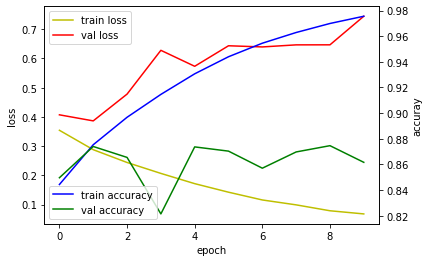

In [42]:
# 학습과정 살펴보기

#print(history.history['loss'])
#print(history.history['accuracy'])
#print(history.history['val_loss'])
#print(history.history['val_accuracy'])

%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')

acc_ax.plot(history.history['accuracy'], 'b', label='train accuracy')
acc_ax.plot(history.history['val_accuracy'], 'g', label='val accuracy')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

# 테스트 데이터에 대한 predict

In [27]:
csv = pd.read_csv('mapping_image.csv') # Image_ID와 Class가 두 개의 빈 column으로 존재하는 csv 파일

_list = list(os.listdir('test_image'))

csv['Image_ID'] = _list

csv.to_csv('mapping_test_image.csv', index=False)

In [43]:
test = pd.read_csv('mapping_test_image2.csv')

test_image = []
for img_name in test.Image_ID:
    img = plt.imread('' + './test_image2/'+img_name)
    test_image.append(img)
test_img = np.array(test_image)

test_image = []
for i in range(0,test_img.shape[0]):
    a = resize(test_img[i], preserve_range=True, output_shape=(100,100)).astype(int)
    test_image.append(a)
test_image = np.array(test_image)

# preprocessing the images
test_image = preprocess_input(test_image)

# extracting features from the images using pretrained model
test_image = base_model.predict(test_image)

# converting the images to 1-D form
test_image = test_image.reshape(7680, 1, 3, 3, 2048) # 7680 = 테스트 이미지 수, (1, 3, 3, 2048): 베이스 모델 통과한 결과값

# zero centered images
test_image = test_image/test_image.max()

# make prediction
predictions_class = model.predict_classes(test_image)
predictions_prob = model.predict(test_image)

In [44]:
print("The screen time of non highlight is", (predictions_class[predictions_class==0].shape[0])/2, "seconds")
print("The screen time of highlight is", (predictions_class[predictions_class==1].shape[0])/2, "seconds")

The screen time of non highlight is 3027.0 seconds
The screen time of highlight is 813.0 seconds


In [45]:
print(list(predictions_class))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 

In [56]:
print('하이라이트라고 예측한 이미지 수: ', list(predictions_class).count(1))
n = 0
for i in range(len(result['Class'])):
    if result['Real_Class'][i] == 1:
        n += 1
        
print('실제 하이라이트 이미지 수: ', n)

하이라이트라고 예측한 이미지 수:  1626
실제 하이라이트 이미지 수:  841


In [46]:
# 0, 1클래스를 추가해서 새로 csv 파일 만듦

csv = pd.read_csv('mapping_test_image2.csv') # test 이미지 파일명이 담긴 csv파일

csv['Class'] = predictions_class # predictions_class은 np.array 형태
    
csv.to_csv('test_result_LSTM1.csv', index=False)

In [47]:
result = pd.read_csv('test_result_LSTM1.csv')

num = 0
for i in range(len(result['Class'])):
    if result['Class'][i] == result['Real_Class'][i]:
        num += 1
        
print('HL인 부분과 HL이 아닌 부분을 동시에 맞췄을 확률:', num/len(result['Class']))

k = 0
for i in range(len(result['Class'])):
    if result['Class'][i] == 1 and result['Real_Class'][i] == 1:
        k += 1
        
print('실제로 HL인 부분중 HL이라고 예측했을 확률:', k/sum(result['Real_Class']))

HL인 부분과 HL이 아닌 부분을 동시에 맞췄을 확률: 0.797265625
실제로 HL인 부분중 HL이라고 예측했을 확률: 0.5410225921521997


train 데이터 : 8대 2의 비율로 HL과 non-HL을 섞은 100x100 크기 54000장

val 데이터: 비슷한 비율로 100*100 크기 9400장

epoch: 10, batch_size: 64, loss: categorical_crossentropy, optimizer: adam

- 이전(나머지는 같고 LSTM 적용 X): base model로 Xception을 사용하였고, Dense 레이어 세 층 사용하여 fine tuning. 

- 현재: 마찬가지로 base model로 Xception을 사용하였고, TimeDistributed 레이어를 사용하여 LSTM에 넣을 수 있는 shape으로 바꿈.
TimeDistributed 중 Conv2D와 Flatten 사용하고, 그 후 Dense 레이어 두 층, LSTM 사용하여 fine tuning. 그 결과 처음 결과보다 val loss가
10배 가까이 줄어들었고, val precision과 val recall도 소폭 상승한 것을 볼 수 있었음.

실제 예측 결과:

- LSTM 적용 이전엔 드래곤이나 바론 같은 몬스터 사냥, 5대 5 대규모 한타 등 큰 특징이 있는 장면들 위주로 HL을 잡은 반면,

- LSTM 적용 후, 그 뿐만 아니라 킬이 나지 않고 간만 보거나 스킬을 주고 받는 1대1, 2대2 장면들도 HL로 잡는 경향, 그러나 이것들이 실제 HL은 아니었음.

- 실제 HL도 당연히 많이 예측함. 그러나, 정확한 측정은 안해봤지만, 체감상 3~40%는 실제 HL을 HL이라고 예측하지 못함.

- LSTM 적용 이전엔 마지막 넥서스 파괴 장면을 HL로 잡지 못했으나 적용 이후엔 HL로 잡음.

- 기타: 미니언 잡는 장면을 가끔 HL로 잡기도 하고, 최종 스코어 및 스텟 장면도 HL로 잡음.

- 실제 HL을 포함해서 앞, 뒤 몇 장면들을 HL로 잡는 경우가 많아짐. LSTM의 영향으로 보임.

이후 할 것:

- 현재 MFCC 데이터를 만드는 중인데, 멀티 input 데이터로 다시 모델을 구성해서 만들어본다면 좀 더 좋은 결과가 나올 것으로 예상.

- 이 모델 구조, 즉 2D CNN + LSTM (with Video + Audio) 을 효철님이 만드신 데이터와 fit 함수(F1 score 기록 가능한)로 다시 적용해볼 예정.